**Library Required**

In [1]:
import random
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import json

from utils.load_networkx import networkx_feat
from utils import macro_unsupervised as unsup
from utils import plot
from utils.emd import Calculate_EMD

# optimization tools
from scipy.stats import norm
import shutil
import sys
import os.path
assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *

print("Import Library Done!")

Import Library Done!


**Load featurized NetworkX graphs of Ensemble P and Ensemble Q**

In [2]:
Ensemble_P = networkx_feat(
    TXT_DATA_PATH = './dataset/Example1/Ensemble_P', 
    MON_SMILES = './tables/SMILES_monomer.txt', 
    FEAT = 'onehot', 
)
Ensemble_P

{'p1': <networkx.classes.graph.Graph at 0x7ff75a027d30>,
 'p2': <networkx.classes.graph.Graph at 0x7ff759fe97c0>}

In [3]:
Ensemble_Q = networkx_feat(
    TXT_DATA_PATH = './dataset/Example1/Ensemble_Q', 
    MON_SMILES = './tables/SMILES_monomer.txt', 
    FEAT = 'onehot', 
)
Ensemble_Q.keys()

dict_keys(['q1', 'q2'])

**Visualize featurized NetworkX graphs of Ensemble P and Ensemble Q**

{0: 'RX1', 1: 'RX2', 2: 'RX1', 3: 'RX2', 4: 'RX1', 5: 'RX2', 6: 'RX1', 7: 'RX2', 8: 'RX1'}


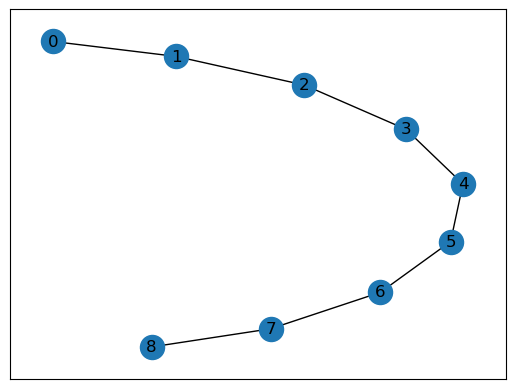

In [4]:
plot.graph(Ensemble_P['p1'])

{0: 'RX2', 1: 'RX1', 2: 'RX2', 3: 'RX1', 4: 'RX2', 5: 'RX1', 6: 'RX2', 7: 'RX1', 8: 'RX2'}


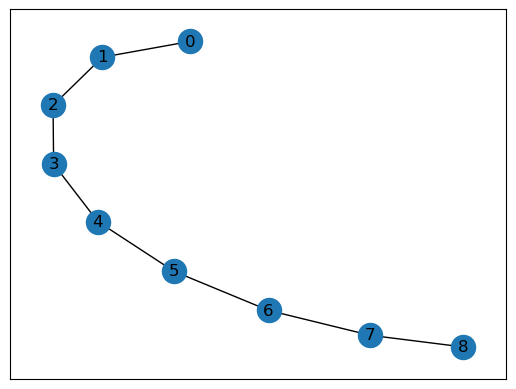

In [5]:
plot.graph(Ensemble_P['p2'])

{0: 'RX1', 1: 'RX1', 2: 'RX1', 3: 'RX2', 4: 'RX2', 5: 'RX2', 6: 'RX1', 7: 'RX1', 8: 'RX1'}


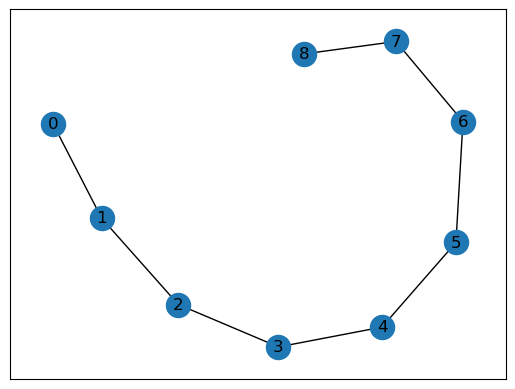

In [6]:
plot.graph(Ensemble_Q['q1'])

{0: 'RX1', 1: 'RX1', 2: 'RX1', 3: 'RX2', 4: 'RX2', 5: 'RX2', 6: 'RX1', 7: 'RX1', 8: 'RX1'}


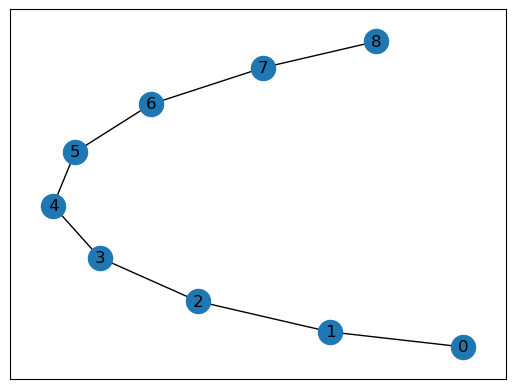

In [7]:
plot.graph(Ensemble_Q['q1'])

**EMD Calculation**

In [8]:
def Calculate_EMD(ensembleP = None,
                  ensembleP_weight = None,
                  ensembleQ = None,
                  ensembleQ_weight = None,
                  alpha = 1,
                  print_details = False
                         ):
  
    Demand = {}
    Supply = {}
    T = {}

    ensembleP_number = len(ensembleP_weight)
    
    ensembleP_weight_sum = sum(ensembleP_weight)
    
    ensembleP_indexs = list(ensembleP.keys())

    for i in range(0, ensembleP_number):
        
            Demand["P" + str(i+1)] = ensembleP_weight[i]/ensembleP_weight_sum

    ensembleQ_number = len(ensembleQ_weight)
    
    ensembleQ_weight_sum = sum(ensembleQ_weight)
    
    ensembleQ_indexs = list(ensembleQ.keys())
   

    for j in range(0, ensembleQ_number):
        
            Supply["Q" + str(j+1)]= ensembleQ_weight[j]/ensembleQ_weight_sum

    for i in range(0,ensembleP_number):
        
        for j in range(0, ensembleQ_number):
            
            GED = unsup.edit_distance(ensembleP[ensembleP_indexs[i]],
                    ensembleQ[ensembleQ_indexs[j]], 
                    node_attr = 'h', 
                    edge_attr = 'e', 
                    upper_bound = 100,
                    indel_mul=1, 
                    sub_mul=1)
            
            N_i = ensembleP[ensembleP_indexs[i]].number_of_nodes()
            
            N_j = ensembleQ[ensembleQ_indexs[j]].number_of_nodes()
            
            T[("P"+str(i+1),"Q"+str(j+1))] = 1-np.exp(-alpha*GED/(0.5*(N_i+N_j)))
            
    # Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # Step 2: Define the decision 
    model.x = Var(CUS, SRC, domain = NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])
        
    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])


    results = SolverFactory('cbc').solve(model)
    print(model.Cost())

    if 'ok' == str(results.Solver.status):
        if print_details == True:
            for s in SRC:
                for c in CUS:
                    if model.x[c,s]() > 0:
                        print("Ship from ", s," to ", c, ":", 
                              model.x[c,s](),"*" ,T[c,s])
        return model.Cost()
        
    else:
        print("No Valid Solution Found")
        return False


In [9]:
EMD = Calculate_EMD(ensembleP = Ensemble_P,
                         ensembleP_weight = [0.5, 0.5],
                         ensembleQ = Ensemble_Q,
                         ensembleQ_weight = [0.5, 0.5],
                         alpha = 1, 
                         print_details = False)

0.28346868942621073


In [10]:
print("EMD(P,Q) = ", EMD)
print("S(P,Q) = ", 1-EMD)

EMD(P,Q) =  0.28346868942621073
S(P,Q) =  0.7165313105737893
